# Population Study Along Line of  Sight to HH24

In [1]:
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u


import matplotlib.colors as colors
#from astropy.visualization import imshow_norm, MinMaxInterval, LogStretch,PercentileInterval, ImageNormalize

import sep
sys.path.append(os.path.expanduser('~/repos/ReipurthBallyProject/src'))
from catalog import *

sys.path.append(os.path.expanduser('~/repos/runawaysearch/src'))
from gaiastars import gaiastars as gs

In [2]:
hh24Eb = SkyCoord(ra='5:46:08.3973',dec='-0:10:00.573', unit=(u.hourangle, u.deg), frame='fk5').icrs
print('HH24 coords: {},{}'.format(hh24Eb.ra.to_string(unit=u.hour, sep=':', precision=3), hh24Eb.dec.to_string(unit=u.degree, sep=':', precision=3)))

HH24 coords: 5:46:08.396,-0:10:00.554


In [3]:
search_radius = 1*u.degree

hh24Eb_cone = gs()

#remove query constraints:
hh24Eb_cone.gaia_source_constraints= [
     '{schema}.gaia_source.parallax > 0.0']

astrometric_errors = [ 'ra_error','dec_error', 'parallax_error',
                'pmra_error', 'pmdec_error','radial_velocity_error']
     
hh24Eb_cone.add_table_columns(astrometric_errors, schema='gaiadr3')

hh24Eb_cone.conesearch(hh24Eb.ra,hh24Eb.dec,search_radius, schema='gaiadr3')
print(f'Cone Search returned {len(hh24Eb_cone.objs)} objects')

INFO: Query finished. [astroquery.utils.tap.core]
Cone Search returned 24733 objects


In [4]:
N=len(hh24Eb_cone.objs)
M_plx = hh24Eb_cone.objs.parallax.isna().sum()
M_plx_0 = (hh24Eb_cone.objs.parallax <= 0.0).sum()
print(f'Total objects returned: {N}, objects missing parallax: {M_plx}, %: {100*M_plx/N:.2f}')
print(f'Total objects returned: {N}, objects negative parallax: {M_plx_0}, %: {100*M_plx_0/N:.2f}')

Total objects returned: 24733, objects missing parallax: 0, %: 0.00
Total objects returned: 24733, objects negative parallax: 0, %: 0.00


In [5]:
print(f'Min distance: {hh24Eb_cone.objs.r_est.min():.0f} pc, Max Distance: {hh24Eb_cone.objs.r_est.max():,.0f} pc')

Min distance: 26 pc, Max Distance: 38,625,314 pc


In [6]:
M_pmra = hh24Eb_cone.objs.pmra.isna().sum()
M_pmdec = hh24Eb_cone.objs.pmdec.isna().sum()
print(f'Total objects returned: {N}, objects missing pmra: {M_pmra}, %: {100*M_pmra/N:.2f}')
print(f'Total objects returned: {N}, objects missing pmdec: {M_pmdec}, %: {100*M_pmdec/N:.2f}')


Total objects returned: 24733, objects missing pmra: 0, %: 0.00
Total objects returned: 24733, objects missing pmdec: 0, %: 0.00


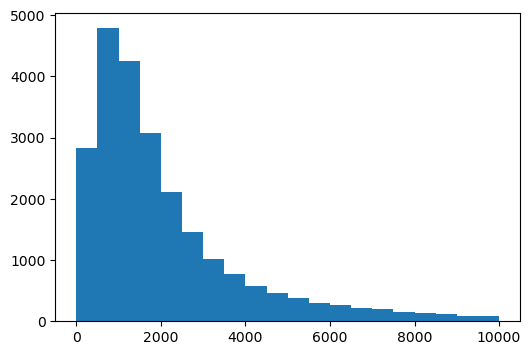

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
zz=ax.hist(hh24Eb_cone.objs.r_est, bins=np.arange(0,10500, 500))


In [8]:
zz[0].sum()

23266.0

In [9]:
zz[1]

array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
        4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
        8000.,  8500.,  9000.,  9500., 10000.])

In [12]:
(hh24Eb_cone.objs.r_est > 10000).sum()

1467

In [13]:
bins_rhs = np.arange(500, 10500, 500)
bins_rhs

array([  500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,
        5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,
        9500, 10000])

In [14]:
objs = hh24Eb_cone.objs

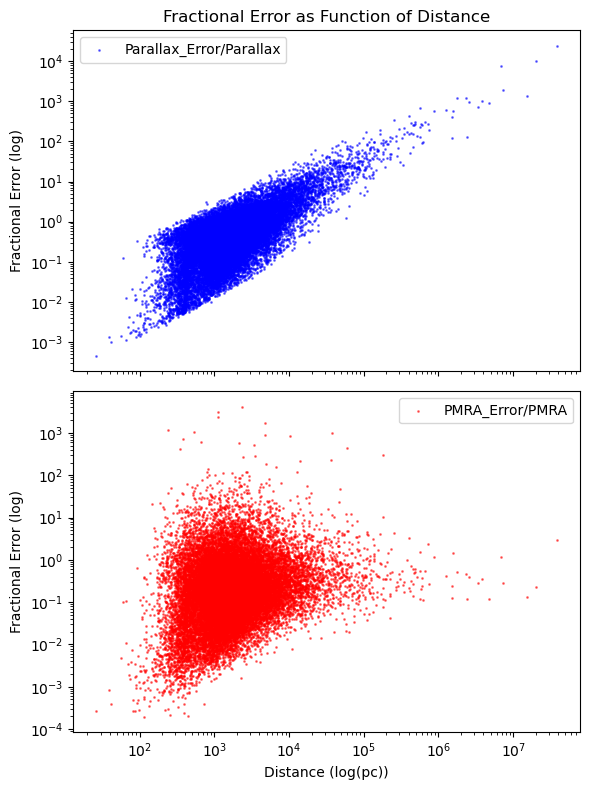

In [15]:
fig, axs = plt.subplots(figsize=(6,8), nrows=2, sharex=True)
axs[0].scatter(objs.r_est, np.sqrt((objs.parallax_error/objs.parallax)**2), color='blue', alpha=0.5, s=1, label='Parallax_Error/Parallax')
axs[1].scatter(objs.r_est, np.sqrt((objs.pmra_error/objs.pmra)**2), s=1, color='red', alpha=0.5, label='PMRA_Error/PMRA')
for ax in axs:
    ax.set_ylabel('Fractional Error (log)')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend()

axs[0].set_title('Fractional Error as Function of Distance')
axs[1].set_xlabel('Distance (log(pc))')

plt.tight_layout()

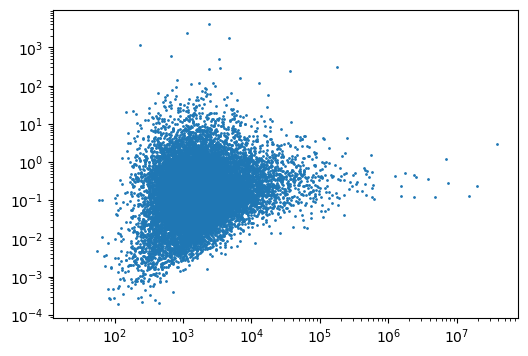

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(objs.r_est, objs.pmra_error/objs.pmra, s=1)
ax.set_xscale('log')
ax.set_yscale('log')

In [17]:
bins_rhs = np.arange(1000, 8000,  1000)
bins_rhs

array([1000, 2000, 3000, 4000, 5000, 6000, 7000])

In [18]:
bin_strs = ['0 <= r < 1000']+[f'{bins_rhs[i-1]} <= r < {bins_rhs[i]}' for i in range(1,len(bins_rhs))] + ['7000 <= r']
bin_strs

['0 <= r < 1000',
 '1000 <= r < 2000',
 '2000 <= r < 3000',
 '3000 <= r < 4000',
 '4000 <= r < 5000',
 '5000 <= r < 6000',
 '6000 <= r < 7000',
 '7000 <= r']

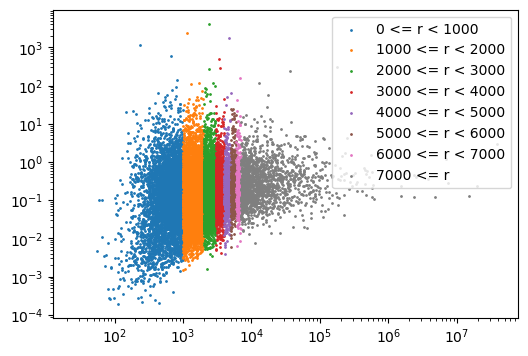

In [19]:
objs['DistBin'] = np.digitize(objs.r_est, bins_rhs, right=False)
fig, ax = plt.subplots(figsize=(6,4))
for bin_no, bin in objs.groupby('DistBin'):
    ax.scatter(bin.r_est, bin.pmra_error/bin.pmra, s=1, label= bin_strs[bin_no])

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [20]:
objs['TotalFracErr'] = np.sqrt( (objs.pmra_error/objs.pmra)**2 +
                                (objs.pmdec_error/objs.pmdec)**2 +
                                (objs.parallax_error/objs.parallax)**2
)


In [26]:
def sky_velocity(gstar_df):
    mu = np.sqrt(gstar_df.pmra**2 + gstar_df.pmdec**2)
    mu_rad = (np.array(mu)*u.mas).to(u.radian).value
    sec = (1*u.year).to(u.second).value
    dist = (np.array(gstar_df.r_est)*u.pc).to(u.km).value 
    vel = mu_rad*dist/sec

    return vel

In [27]:
# position angles
def pos_angle(pmra, pmdec):
    # degrees east of north
    rad = np.pi/2 - np.arctan2(pmdec, pmra) 
    posangle = np.degrees(np.remainder(2*np.pi+rad, 2*np.pi))
    return posangle

In [28]:
objs['SkyVelocity'] = sky_velocity(objs)
objs['PosAngle'] = pos_angle(objs.pmra, objs.pmdec)

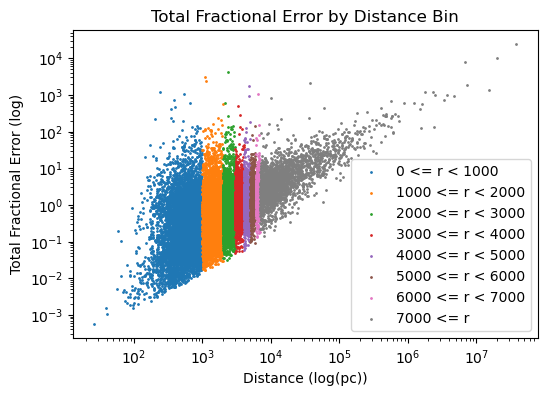

In [29]:
fig, ax = plt.subplots(figsize=(6,4))
for bin_no, bin in objs.groupby('DistBin'):
    ax.scatter(bin.r_est, bin.TotalFracErr, s=1, label= bin_strs[bin_no])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Total Fractional Error (log)')
ax.set_xlabel('Distance (log(pc))')
ax.set_title('Total Fractional Error by Distance Bin')
ax.legend()

In [30]:
for bin_no, bin in objs.groupby('DistBin'):
    print(f'Bin: {bin_strs[bin_no]}, N: {len(bin)}')

Bin: 0 <= r < 1000, N: 7630
Bin: 1000 <= r < 2000, N: 7321
Bin: 2000 <= r < 3000, N: 3572
Bin: 3000 <= r < 4000, N: 1790
Bin: 4000 <= r < 5000, N: 1028
Bin: 5000 <= r < 6000, N: 673
Bin: 6000 <= r < 7000, N: 475
Bin: 7000 <= r, N: 2244


In [31]:
for bin_no, bin in objs.groupby('DistBin'):
    bin_sort = bin.sort_values('TotalFracErr', ascending=True)
    print(f'---------- bin no: {bin_no}, range: {bin_strs[bin_no]}----------------')
    print(bin_sort.head(3)[['r_est','TotalFracErr']])
    print()

---------- bin no: 0, range: 0 <= r < 1000----------------
           r_est  TotalFracErr
4996   25.935966      0.000558
16858  40.994879      0.001076
14148  39.244642      0.001574

---------- bin no: 1, range: 1000 <= r < 2000----------------
             r_est  TotalFracErr
2754   1077.282037      0.016817
9116   1075.356239      0.017160
24481  1005.262033      0.018362

---------- bin no: 2, range: 2000 <= r < 3000----------------
             r_est  TotalFracErr
15423  2268.453937      0.031105
24066  2001.384331      0.035641
18189  2479.201005      0.035739

---------- bin no: 3, range: 3000 <= r < 4000----------------
             r_est  TotalFracErr
14870  3019.559779      0.047532
15199  3389.044884      0.054843
7532   3095.035078      0.055386

---------- bin no: 4, range: 4000 <= r < 5000----------------
             r_est  TotalFracErr
13375  4094.656212      0.060366
2407   4223.540254      0.064779
17241  4082.630190      0.074827

---------- bin no: 5, range: 5000 <=

In [45]:
objs_best = pd.concat([bin.sort_values('TotalFracErr').head(50) for bin_no, bin in objs.groupby('DistBin')])

/tmp/ipykernel_4882/2732459656.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  zz=g.set_xticklabels(bin_strs,rotation=90)


Text(0.5, 1.0, 'Total Fractional Error by Distance Bin\nLowest 50 in Each Bin')

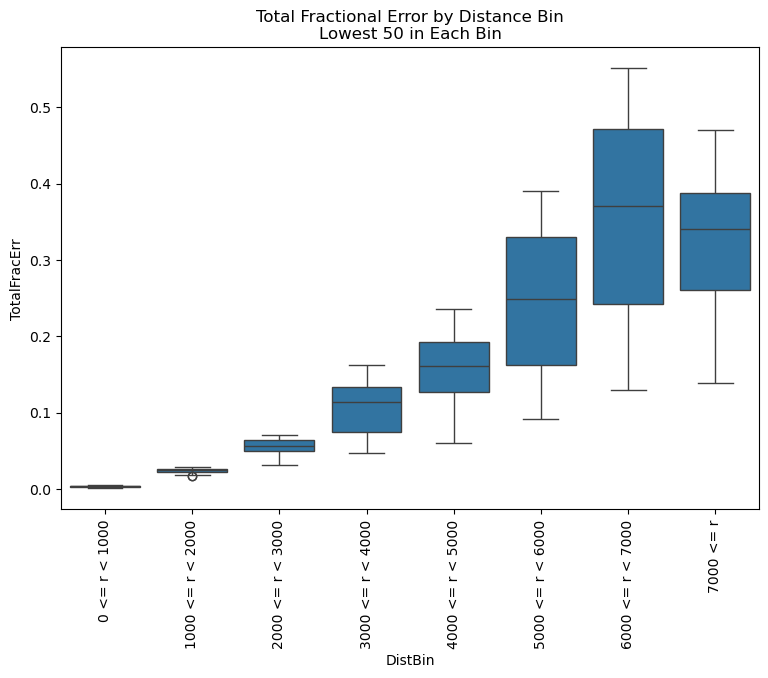

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(9,6))
g = sns.boxplot(ax=ax, data=objs_best, x='DistBin', y='TotalFracErr', log_scale=False)

zz=g.set_xticklabels(bin_strs,rotation=90)
ax.set_title('Total Fractional Error by Distance Bin\nLowest 50 in Each Bin')

In [34]:
from astropy.stats import circmean, circstd

def agg_func(indx, df):
    N = len(df)
    cm = np.degrees(circmean(np.radians(df.PosAngle)))
    cmstd = np.degrees(circstd(np.radians(df.PosAngle)))
    cm_e = cmstd/np.sqrt(N)
    v = df.SkyVelocity.mean()
    vstd = df.SkyVelocity.std()
    v_e = vstd/np.sqrt(N)
    #rng_str = df.Range.iloc[0]

    return {'DistBin':indx, 'N':N, 'SkyVelocity':v, 'SkyVelocityError':v_e,
            'PosAngle': cm, 'PosAngleError': cm_e}

In [53]:
summary_tbl = Table(rows=[agg_func(rng, df) for rng, df in objs_best.groupby('DistBin')],
                    units = [None, None, u.km/u.second, u.km/u.second, u.deg, u.deg])
for c in ['SkyVelocity', 'SkyVelocityError', 'PosAngle', 'PosAngleError']:
    summary_tbl[c].info.format='.2f'


dbs = np.array(summary_tbl['DistBin'])
summary_tbl['Range'] = [bin_strs[db] for db in dbs]
cols = ['DistBin','Range', 'N','SkyVelocity','SkyVelocityError','PosAngle','PosAngleError']
summary_tbl[cols]

DistBin,Range,N,SkyVelocity,SkyVelocityError,PosAngle,PosAngleError
,,,km / s,km / s,deg,deg
int64,str16,int64,float64,float64,float64,float64
0,0 <= r < 1000,50,36.19,3.69,166.77,7.61
1,1000 <= r < 2000,50,37.60,3.23,144.09,9.23
2,2000 <= r < 3000,50,36.44,4.46,138.27,8.42
3,3000 <= r < 4000,50,38.95,3.74,135.65,9.10
4,4000 <= r < 5000,50,51.83,7.98,108.28,9.24
5,5000 <= r < 6000,50,37.98,2.95,107.11,9.10
6,6000 <= r < 7000,50,43.59,2.86,57.10,9.04
7,7000 <= r,50,50.72,6.09,106.46,8.62


In [58]:
yso_tbl = load_catalog('/home/kevin/Documents/HH24/Fang2009/yso_catalog.xml')
yso_gaia = gs()
yso_gaia.from_source_idlist(yso_tbl['GaiaDR3'])

#calculate sky velocity
yso_gaia.objs['SkyVelocity'] = sky_velocity(yso_gaia.objs)

# position angle of velocity
yso_gaia.objs['PosAngle'] = pos_angle(yso_gaia.objs.pmra, yso_gaia.objs.pmdec)

yso_gaia.objs['DistBin'] = 0

yso_gaia.objs.set_index('SOURCE_ID', inplace=True)

# exclude these three source_ids (see reg_giants.ipynb)
print(f'Len before drop: {len(yso_gaia.objs)}')
exclude_list = [3219117536412592000,3219207494502113792, 3219209861029037952 ]
yso_gaia.objs.drop(index=exclude_list, inplace=True)
print(f'Len after drop: {len(yso_gaia.objs)}')

INFO: Query finished. [astroquery.utils.tap.core]
Len before drop: 130
Len after drop: 127


In [59]:
summary_yso = Table(rows=[agg_func(rng, df) for rng, df in yso_gaia.objs.groupby('DistBin')],
                    units = [None, None, u.km/u.second, u.km/u.second, u.deg, u.deg])
for c in ['SkyVelocity', 'SkyVelocityError', 'PosAngle', 'PosAngleError']:
    summary_yso[c].info.format='.2f'


dbs = np.array(summary_yso['DistBin'])
summary_yso['Range'] = [bin_strs[db] for db in dbs]
cols = ['DistBin','Range', 'N','SkyVelocity','SkyVelocityError','PosAngle','PosAngleError']
summary_yso[cols]

DistBin,Range,N,SkyVelocity,SkyVelocityError,PosAngle,PosAngleError
,,,km / s,km / s,deg,deg
int64,str13,int64,float64,float64,float64,float64
0,0 <= r < 1000,127,2.77,0.15,-152.84,4.33
